# Introduction  

**!Recommend to view the notebook on Github!**  
Github Link : https://github.com/heartcored98/CH485_AI_Chemistry/blob/master/Practice3_Tox21_MLP/Assignment3_Tox21_MLP.ipynb

In this jupyter notebook, a toxicity of the molecular will be classified with the **Multi Layer Perceptron(MLP)** on **Tox21** dataset.  
**Tox21** dataset consists of molecular smile strings as inputs and binary labels as outputs.  

This notebook has following features  
- Convert smile string into _Morgan Fingerprints_(error handling enabled) with **RDkit**  
- Synthesis _insufficient class data_ by **imblearn SMOTE** algorithm in order to handle class imbalanced dataset 
- Support data spliting for _K-fold vallidation_ process easily
- Manage experiment and model _hyperparameters_ at once with **argparse**  
- _Visualize_ experiment results with minimal changes of codes with **seaborn** and **pandas Dataframe**  
- _Visualize_ experiment results with 95% _Confidence Intervals_

Throughout the notebook, there are **6** experiments with following investigation purpose.  
Note that **classification performance** includes _binary classification accuracy_ and _roc-auc metric._  
1. Influence of the **Number of hidden unit** toward **classification performance**.  
2. Influence of the **Number of hidden layer** in the SVC model toward **classification performance**.  
3. Influence of the **Number of hidden unit and layer** coefficient toward **classification performance**.
4. Influence of the **Dropout** rate toward **classification performance**.
5. Influence of the **L2 regularization** coefficient toward **classification performance**.
6. Influence of the **Dropout**, **L2 regularization** and **n_layer** toward **classification performance**.


In [ ]:
import time
from torch.multiprocessing import Pool, Process, set_start_method
from copy import deepcopy
import argparse
import sys
import traceback

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from utils import *


parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.seed = 123
args.nbits = 2048
args.n_splits = 5
args.test_size = 0.2
args.shuffle = True


np.random.seed(args.seed)
torch.manual_seed(args.seed)
list_tox_type = ['nr-ahr', 'nr-ar-lbd', 
                 'nr-ar', 'nr-aromatase', 
                 'nr-er-lbd', 'nr-er', 
                 'nr-ppar-gamma', 'sr-are', 
                 'sr-atad5', 'sr-hse', 
                 'sr-mmp', 'sr-p53']


# Prepare Dataset by Generating Molecular Fingerprints  

Since the molecular information is provided within **smile** string form, we need to convert this strings into fixed-dimension feature vector. 
For this purpose, a **Morgan Fingerprints** methods was very suitable as it produces fixed-size vector with given dimension while capturing chemical information as well.  

You can produce fingerprint with specified dimension with arguments **nBits**  
Also, there are some **smile** string which cannot be converted into fingerprints so we excluded them during dataset preparation.  

`RDkit` Fingerprint Ref : http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints

In [ ]:
dict_partition = dict()
for tox_type in list_tox_type:
    args.tox_type = tox_type
    X, y = make_dataset(args)
    list_partition = make_partition(X, y, args)
    dict_partition[args.tox_type] = list_partition

## Dictionary saves experiment results with their hyperparatemr

In [ ]:
exp_data = dict()

# MLP Model Architecture Define

The structure of the MLP mainly consists of linear layer, ReLU activation layer and dropout layer.  
At the end of the model, a sigmoid layer is adopted.

In [ ]:
def construct_model(args):
    list_module = list()
    list_module += [nn.Linear(args.input_dim, args.hidden_dim), nn.ReLU()]

    if args.n_layer-2 > 0:
        for _ in range(args.n_layer-2):
            list_module.append(nn.Linear(hidden_dim, hidden_dim))
            list_module.append(nn.ReLU())
            if args.dropout_rate > 0:
                list_module.append(nn.Dropout(args.dropout_rate))
            
    list_module.append(nn.Linear(args.hidden_dim, args.output_dim))
    list_module.append(nn.Sigmoid())
    
    model = nn.Sequential(*list_module)
    return model 

# Experiment Template  

This section includes template code for launching individual experiments with given hyperparameters and experiment settings such as kernel type, C, gamma, fingerprint dimension, number of dataset fold and etc.  

- Data synthesis for insufficient class is shown during k-folding dataset.   
- Also, it includes function to execute each experiments in subprocess in order to maximize system resource utlization.
- **args** object contains all the hyperparameters and experiments settings to control the experiments.  

sklearn **k-fold** Ref : http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold  
Using **SMOTE** Ref : https://beckernick.github.io/oversampling-modeling/  
Using Custom **Dataset** and **DataLoader** Ref : https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel 

In [ ]:
def train(model, partition, optimizer, criterion, args):
    
    best_test_acc = 0
    best_roc_auc = 0
    cnt_iter = 0
    dict_train_loss = dict()
    dict_val_loss = dict()
    dict_acc_test = dict()
    dict_roc_auc_test = dict()
    
    data_iter = DataLoader(
        partition['train'],
        batch_size=args.batch_size,
        shuffle=args.shuffle
    )
    
    for epoch in range(args.epoch):
        epoch_train_loss = 0
        for batch_idx, batch in enumerate(data_iter):
            X, y = Variable(batch[0]), Variable(batch[1])
            X, y = X.to(args.device).float(), y.to(args.device).float()
            y = y.view(-1, 1)

            model.train()
            optimizer.zero_grad()
            
            pred_y = model(X)
            pred_y.require_grad = False
            train_loss = criterion(pred_y, y)
            epoch_train_loss += train_loss.item()
            train_loss.backward()
            optimizer.step()
            
            cnt_iter += 1
            
        dict_train_loss[cnt_iter/len(data_iter)] = train_loss.item()
        val_loss = validate(model, partition, criterion, args)
        dict_val_loss[cnt_iter/len(data_iter)] = val_loss
        test_acc, test_roc_auc = evaluate(model, partition, args)
        dict_acc_test[cnt_iter/len(data_iter)] = test_acc
        dict_roc_auc_test[cnt_iter/len(data_iter)] = test_roc_auc
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_roc_auc = test_roc_auc

    return model, pd.Series(dict_train_loss), pd.Series(dict_val_loss), pd.Series(dict_acc_test), pd.Series(dict_roc_auc_test), best_test_acc, best_roc_auc

def validate(model, partition, criterion, args):
    epoch_val_loss = 0
    model.eval()
    data_iter = DataLoader(
        partition['val'],
        batch_size=args.batch_size,
        shuffle=args.shuffle
    )
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_iter):
            X, y = Variable(batch[0]), Variable(batch[1])
            X, y = X.to(args.device).float(), y.to(args.device).float()
            y = y.view(-1, 1)
            pred_y = model(X)
            
            val_loss = criterion(pred_y, y)
            epoch_val_loss += val_loss.item()
            
    return epoch_val_loss / len(data_iter)

def evaluate(model, partition, args):
    model.eval()
    data_iter = DataLoader(
        partition['test'],
        batch_size=args.batch_size,
        shuffle=False
    )
    
    list_y = list()
    list_pred_y = list()
    with torch.no_grad():
        list_accu = list()
        list_roc_auc = list()
        for batch_idx, batch in enumerate(data_iter):
            X, y = Variable(batch[0]), Variable(batch[1])
            X, y = X.to(args.device).float(), y.to(args.device).float()
            y = y.view(-1, 1)

            pred_y = model(X)
            target = y >= 0.5
            output = pred_y >= 0.5
            acc = float(output.eq(target).sum()) / target.numel()
            list_accu.append(acc)
            list_y += list(y.cpu().numpy())
            list_pred_y += list(pred_y.cpu().numpy())
    roc_auc = roc_auc_score(list_y, list_pred_y)

    return np.array(list_accu).mean(), roc_auc

In [ ]:
def experiment(partition, args):
    model = construct_model(args)
    model.to(args.device)
    criterion = nn.BCELoss()
    
    # Initialize Optimizer
    if args.optim == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
        
    model, train_loss, val_loss, acc_test, roc_auc_test, acc, roc_auc = train(model, partition, optimizer, criterion, args)
    return {'acc':acc, 'roc_auc':roc_auc, 'train_loss':train_loss, 'val_loss':val_loss, 'acc_test':acc_test, 'roc_auc_test':roc_auc_test}

In [ ]:
def kfold_experiment(list_partition, args):    
    list_static = list()
    list_train_loss = list()
    list_val_loss = list()
    list_acc_test = list()
    list_roc_auc_test = list()
    list_result = list()
    for partition in list_partition:
        result = experiment(partition, args)
        list_static.append((result['acc'], result['roc_auc']))
        list_train_loss.append(result['train_loss'])
        list_val_loss.append(result['val_loss'])
        list_acc_test.append(result['acc_test'])
        list_roc_auc_test.append(result['roc_auc_test'])
        list_result.append(result)
        
    df = pd.DataFrame(list_static, columns=['acc', 'roc_auc'])
    train_loss = np.array(list_train_loss).mean(axis=0)
    val_loss = np.array(list_val_loss).mean(axis=0)
    acc_test = np.array(list_acc_test).mean(axis=0)
    roc_auc_test = np.array(list_roc_auc_test).mean(axis=0)
    
    for result in list_result:
        result.update({'acc_mean':df['acc'].mean(), 'acc_std':df['acc'].std(), 
                  'ra_mean':df['roc_auc'].mean(), 'ra_std':df['roc_auc'].std(),
                  'train_loss':train_loss, 'val_loss':val_loss,
                      'acc_test':acc_test, 'roc_auc_test':roc_auc_test})

    return list_result

In [ ]:
def subproc_experiment(args):
    ts = time.time()
#     try:
    list_partition = args.list_partition
    list_result = kfold_experiment(list_partition, args)
    te = time.time()

    for result in list_result:
        result.update({'elapsed':te-ts})
        temp_args = deepcopy(vars(args))
        del temp_args['list_partition']
        result.update(temp_args)
    """
    except Exception as e:
        args.msg = traceback.print_tb(e.__traceback__)
    """
    return list_result
    
def callback_experiment(list_result):
    
    result = list_result[0] 
    output = "Acc Mean: {:0.3f} Acc STD: {:0.3f} RA Mean: {:0.3f} RA STD: {:0.3f} Elapsed: {:3.1f}"
    output = output.format(result['acc_mean'],
                           result['acc_std'],
                           result['ra_mean'],
                           result['ra_std'],
                           result['elapsed'])
    print(output)
    
    global exp_data
    list_experiments = exp_data.get(args.exp_name, [])
    list_experiments += list_result

# Experiemnt1. Effect of Hidden Unit

Variable : Number of hidden unit, toxicity type

**Pandas Dataframe** construction Ref : http://pbpython.com/pandas-list-dict.html  
**Pyplot Grid** Ref : https://matplotlib.org/users/gridspec.html  

In [ ]:
%%time
args.exp_name = 'exp_hidden_dim'
args.input_dim = 2048
args.output_dim = 1
args.n_layer = 2
args.dropout_rate = 0.0
args.lr = 0.001
args.l2_coef = 0
args.optim = 'RMSProp'
args.epoch = 20
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

exp_data['exp_hidden_dim'] = list()
list_hidden_dim = [1, 4, 16, 64, 256, 1024, 4096]

# pool = Pool(processes=14)
for tox_type in list_tox_type[:3]:
    for hidden_dim in list_hidden_dim:
        args.tox_type = tox_type
        args.hidden_dim = hidden_dim
        args.list_partition = dict_partition[tox_type]
        result = subproc_experiment(args)
        callback_experiment(result)
#         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

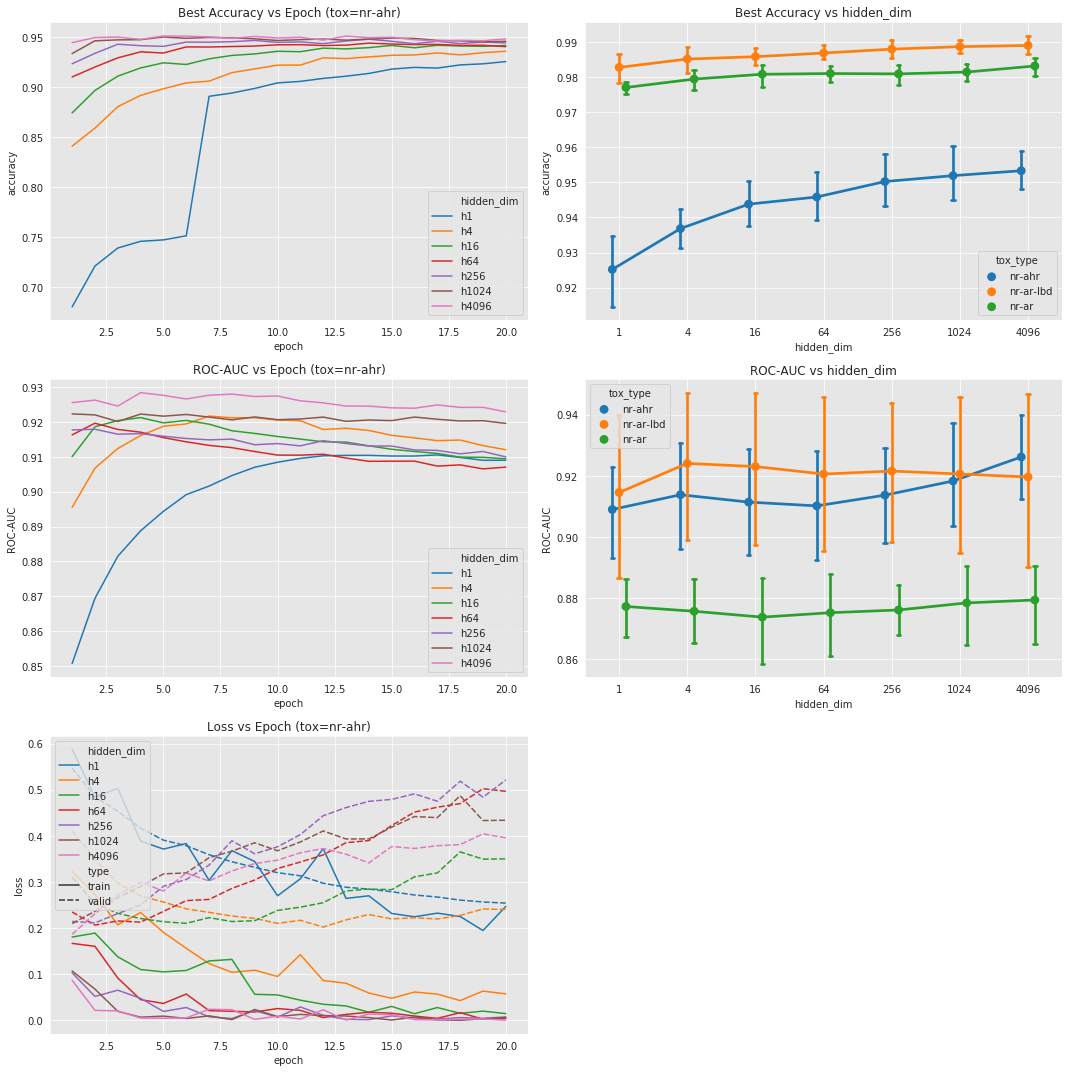

In [165]:
exp_name = 'exp_hidden_dim'
df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'tox_type', 'hidden_dim']]

variable = 'hidden_dim'
variable2 = 'tox_type'
list_loss = list()
list_test = list()

for value in df[variable].unique():
    for result in exp_data[exp_name]:
        if result[variable] == value and result['tox_type'] == 'nr-ahr':
            for i, data in enumerate(result['train_loss']):
                list_loss.append({'epoch':i+1, 'loss':data, 'type':'train', variable:'h'+str(value)})
            for i, data in enumerate(result['val_loss']):
                list_loss.append({'epoch':i+1, 'loss':data, 'type':'valid', variable:'h'+str(value)})
            for i, data in enumerate(result['acc_test']):
                list_test.append({'epoch':i+1, 'test':data, 'type':'acc', variable:'h'+str(value)})
            for i, data in enumerate(result['roc_auc_test']):
                list_test.append({'epoch':i+1, 'test':data, 'type':'roc_auc', variable:'h'+str(value)})
            break
            
df_loss = pd.DataFrame(list_loss)
df_test = pd.DataFrame(list_test)


fig = plt.figure(figsize=(15,15))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
gs = gridspec.GridSpec(3, 2)

ax = plt.subplot(gs[0,1])
grid = sns.pointplot(x="hidden_dim", y="acc", hue="tox_type", data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax)
grid.set_title("Best Accuracy vs {}".format(variable))
grid.set_ylabel("accuracy")
grid.grid(True)

ax = plt.subplot(gs[0,0])
df_acc = df_test.loc[df_test['type'] == 'acc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, data=df_acc, ax=ax)
grid.set_title("Best Accuracy vs Epoch (tox=nr-ahr)")
grid.set_ylabel("accuracy")

ax = plt.subplot(gs[1,1])
grid = sns.pointplot(x="hidden_dim", y="roc_auc", hue="tox_type", data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax)
grid.set_title("ROC-AUC vs {}".format(variable))
grid.set_ylabel("ROC-AUC")
grid.grid(True)

ax = plt.subplot(gs[1,0])
df_roc_auc = df_test.loc[df_test['type'] == 'roc_auc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, data=df_roc_auc, ax=ax)
grid.set_title("ROC-AUC vs Epoch (tox=nr-ahr)")
grid.set_ylabel("ROC-AUC")

ax = plt.subplot(gs[2,0])
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style='type', data=df_loss, ax=ax)
grid.set_title("Loss vs Epoch (tox=nr-ahr)")

plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

## Result and Discussion  

- Both accuracy and roc-auc are increased through the training epoch
- The model with smaller number of hidden unit is less likely to be trained 

# Experiment2. Effect of Hidden Layer  

Variable : Number of hidden Layer, toxicty type

In [ ]:
%%time
args.exp_name = 'exp_n_layer'
args.input_dim = 2048
args.hidden_dim = 1024
args.output_dim = 1
args.dropout_rate = 0.0
args.lr = 0.001
args.l2_coef = 0
args.optim = 'RMSProp'
args.epoch = 20
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp_data[args.exp_name] = list()
list_n_layer = [2,3,4,5,6,7,8,9,10]

# pool = Pool(processes=14)
for tox_type in list_tox_type[:3]:
    for n_layer in list_n_layer:
        args.tox_type = tox_type
        args.n_layer = n_layer
        args.list_partition = dict_partition[tox_type]
        result = subproc_experiment(args)
        callback_experiment(result)
#         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

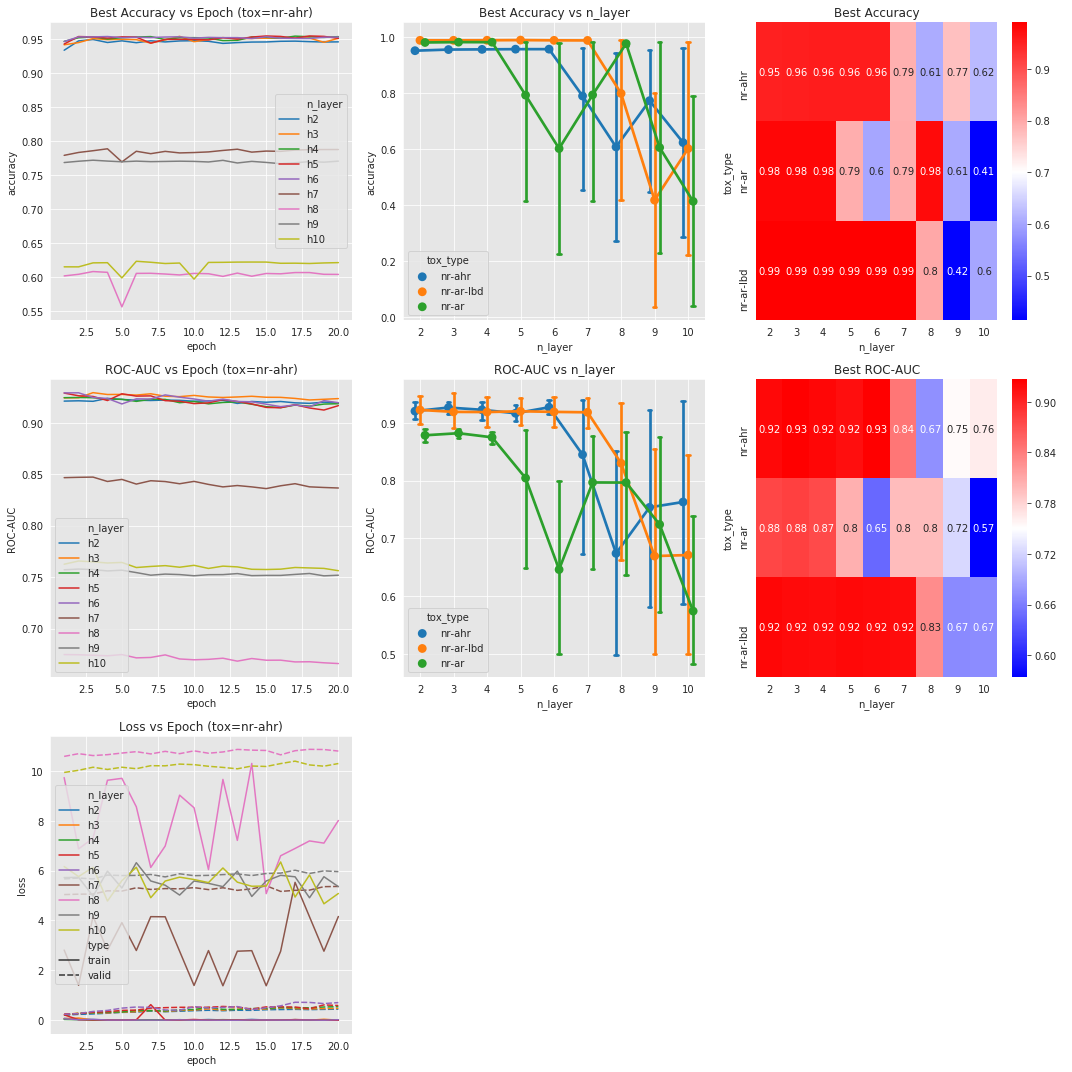

In [163]:
exp_name = 'exp_n_layer'
df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'tox_type', 'n_layer']]

variable = 'n_layer'
variable2 = 'tox_type'
list_loss = list()
list_test = list()

for value in df[variable].unique():
    for result in exp_data[exp_name]:
        if result[variable] == value and result['tox_type'] == 'nr-ahr':
            for i, data in enumerate(result['train_loss']):
                list_loss.append({'epoch':i+1, 'loss':data, 'type':'train', variable:'h'+str(value)})
            for i, data in enumerate(result['val_loss']):
                list_loss.append({'epoch':i+1, 'loss':data, 'type':'valid', variable:'h'+str(value)})
            for i, data in enumerate(result['acc_test']):
                list_test.append({'epoch':i+1, 'test':data, 'type':'acc', variable:'h'+str(value)})
            for i, data in enumerate(result['roc_auc_test']):
                list_test.append({'epoch':i+1, 'test':data, 'type':'roc_auc', variable:'h'+str(value)})
            break
            
df_loss = pd.DataFrame(list_loss)
df_test = pd.DataFrame(list_test)


fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

grid = sns.pointplot(x="n_layer", y="acc", hue="tox_type", data=df, ci=95, capsize=0.1, dodge=0.3, ax=ax[0][1])
grid.set_title("Best Accuracy vs {}".format(variable))
grid.set_ylabel("accuracy")
grid.grid(True)

df_acc = df_test.loc[df_test['type'] == 'acc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, data=df_acc, ax=ax[0][0])
grid.set_title("Best Accuracy vs Epoch (tox=nr-ahr)")
grid.set_ylabel("accuracy")

df_acc = pd.DataFrame(df.groupby([variable2, variable])['acc'].mean())
df_acc.reset_index(level=df_acc.index.names, inplace=True)
df_acc = df_acc.pivot(index=variable2, columns=variable, values='acc')
grid = sns.heatmap(df_acc, annot=True, ax=ax[0][2], cmap='bwr')
grid.set_title("Best Accuracy")

grid = sns.pointplot(x="n_layer", y="roc_auc", hue="tox_type", data=df, ci=95, capsize=0.1, dodge=0.3, ax=ax[1][1])
grid.set_title("ROC-AUC vs {}".format(variable))
grid.set_ylabel("ROC-AUC")
grid.grid(True)

df_roc_auc = df_test.loc[df_test['type'] == 'roc_auc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, data=df_roc_auc, ax=ax[1][0])
grid.set_title("ROC-AUC vs Epoch (tox=nr-ahr)")
grid.set_ylabel("ROC-AUC")

df_roc_auc = pd.DataFrame(df.groupby([variable2, variable])['roc_auc'].mean())
df_roc_auc.reset_index(level=df_roc_auc.index.names, inplace=True)
df_roc_auc = df_roc_auc.pivot(index=variable2, columns=variable, values='roc_auc')

grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][2], cmap='bwr')
grid.set_title("Best ROC-AUC")

grid = sns.lineplot(x='epoch', y='loss', hue=variable, style='type', data=df_loss, ax=ax[2][0])
grid.set_title("Loss vs Epoch (tox=nr-ahr)")

ax[-1,-1].axis('off')
ax[-1,-2].axis('off')

plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

## Result and Discussion  

- More than 1 epoch is meaningless since accuracy and roc-auc does not change throughout the epoch.  
- Deeper model is more likely to be trained in unstable manner. 

# Experiment3. Effect of Hidden Unit and Hidden Layer  

Variable : Number of hidden unit, Number of the hidden layer

In [ ]:
%%time
args.exp_name = 'exp_hidden_dim_layer'
args.input_dim = 2048
args.output_dim = 1
args.dropout_rate = 0.0
args.lr = 0.001
args.l2_coef = 0
args.optim = 'RMSProp'
args.epoch = 20
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.tox_type = 'nr-ahr'

exp_data['exp_hidden_dim_layer'] = list()
list_hidden_dim = [16, 64, 256, 1024]
list_n_layer = [2,3,4,5,6]

# pool = Pool(processes=14)
for hidden_dim in list_hidden_dim[:]:
    for n_layer in list_n_layer:
        args.hidden_dim = hidden_dim
        args.n_layer = n_layer
        args.list_partition = dict_partition[args.tox_type]
        result = subproc_experiment(args)
        callback_experiment(result)
#         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

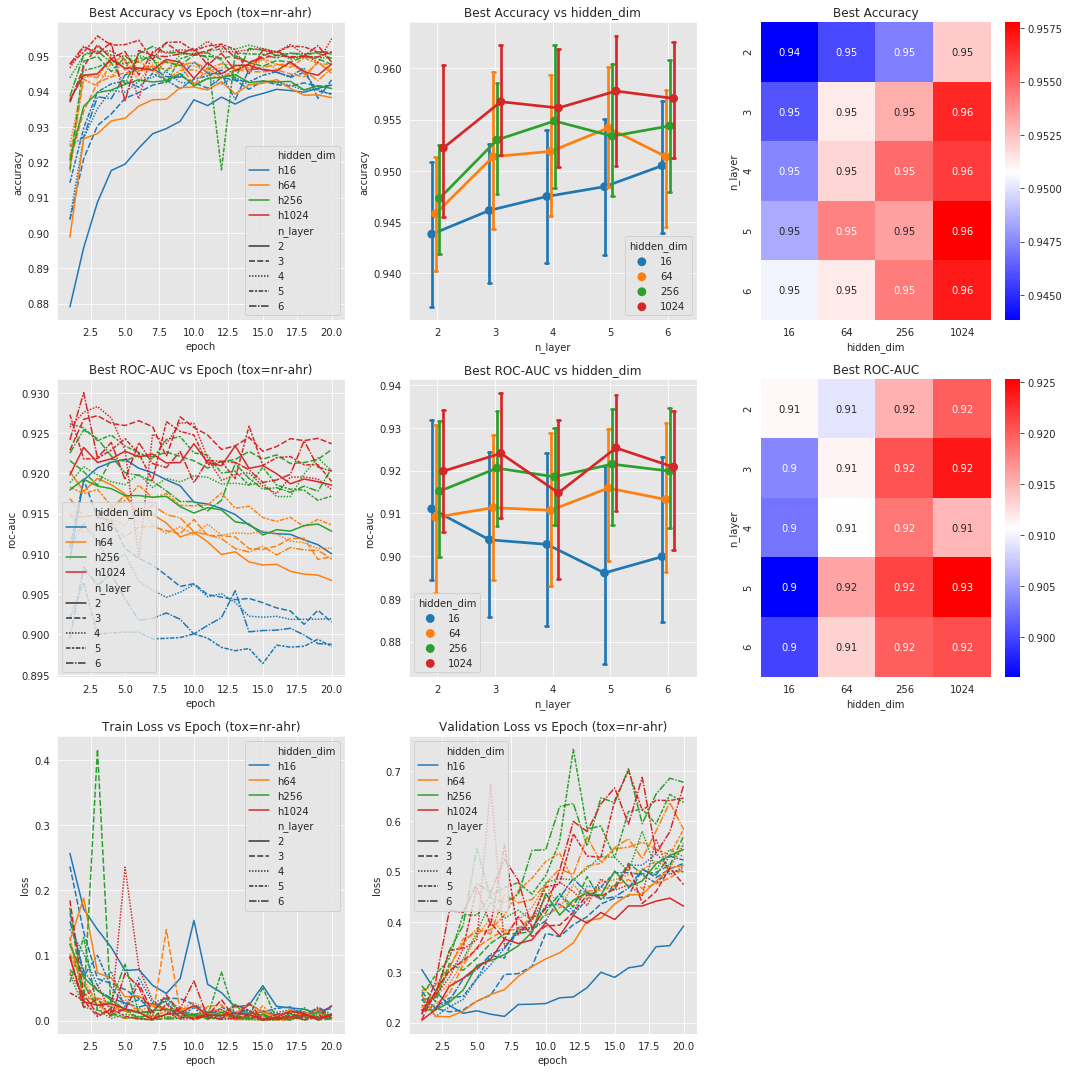

In [166]:
exp_name = 'exp_hidden_dim_layer'

df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'n_layer', 'hidden_dim']]
df = df.loc[df['hidden_dim'] != 1]
df = df.loc[df['hidden_dim'] != 4]

variable = 'hidden_dim'
variable2 = 'n_layer'
list_loss = list()
list_test = list()

for value in df[variable].unique():
    for value2 in df[variable2].unique():
        for result in exp_data[exp_name]:
            if result[variable] == value and result[variable2] == value2:
                for i, data in enumerate(result['train_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'train', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['val_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'valid', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['acc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'acc', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['roc_auc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'roc_auc', variable:'h'+str(value), variable2:value2})
                break

df_loss = pd.DataFrame(list_loss)
df_test = pd.DataFrame(list_test)


fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_acc = df_test.loc[df_test['type'] == 'acc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_acc, ax=ax[0][0])
grid.set_title("Best Accuracy vs Epoch (tox=nr-ahr)")
grid.set_ylabel("accuracy")

df_acc = pd.DataFrame(df.groupby([variable2, variable])['acc'].mean())
df_acc.reset_index(level=df_acc.index.names, inplace=True)
df_acc = df_acc.pivot(index=variable2, columns=variable, values='acc')

grid = sns.pointplot(x="n_layer", y="acc", hue="hidden_dim", data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[0][1])
grid.set_title("Best Accuracy vs {}".format(variable))
grid.set_ylabel("accuracy")
grid.grid(True)
grid = sns.heatmap(df_acc, annot=True, ax=ax[0][2], cmap='bwr')
grid.set_title("Best Accuracy")

df_roc_auc = df_test.loc[df_test['type'] == 'roc_auc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_roc_auc, ax=ax[1][0])
grid.set_title("Best ROC-AUC vs Epoch (tox=nr-ahr)")
grid.set_ylabel("roc-auc")

df_roc_auc = pd.DataFrame(df.groupby([variable2, variable])['roc_auc'].mean())
df_roc_auc.reset_index(level=df_roc_auc.index.names, inplace=True)
df_roc_auc = df_roc_auc.pivot(index=variable2, columns=variable, values='roc_auc')

grid = sns.pointplot(x="n_layer", y="roc_auc", hue="hidden_dim", data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[1][1])
grid.set_title("Best ROC-AUC vs {}".format(variable))
grid.set_ylabel("roc-auc")
grid.grid(True)
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][2], cmap='bwr')
grid.set_title("Best ROC-AUC")

df_train = df_loss.loc[df_loss['type'] == 'train']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_train, ax=ax[2][0])
grid.set_title("Train Loss vs Epoch (tox=nr-ahr)")

df_valid = df_loss.loc[df_loss['type'] == 'valid']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_valid, ax=ax[2][1])
grid.set_title("Validation Loss vs Epoch (tox=nr-ahr)")

ax[-1, -1].axis('off')

plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

## Result and Discussion  

- The performance of accuracy were increased as the model get deeper and wider.  
- The performance of accuracy and roc-auc were increased as the model get deeper when the model is wide.  
- Deeper and Wider model was best.

# Experiment4. Effect of Dropout Rate

Variable : Dropout rate, Number of hidden layer

In [ ]:
%%time
args.exp_name = 'exp_dropout_rate'
args.input_dim = 2048
args.hidden_dim = 1024
args.output_dim = 1
args.lr = 0.001
args.l2_coef = 0
args.optim = 'RMSProp'
args.epoch = 20
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.tox_type = 'nr-ahr'
exp_data[args.exp_name] = list()
list_dp_rate = [i*0.2 for i in range(5)]
list_n_layer = [2,4,8,10,12]

# pool = Pool(processes=14)
for n_layer in list_n_layer:
    for dp_rate in list_dp_rate:
        args.n_layer = n_layer
        args.dropout_rate = dp_rate
        args.list_partition = dict_partition[tox_type]
        result = subproc_experiment(args)
        callback_experiment(result)
    #         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

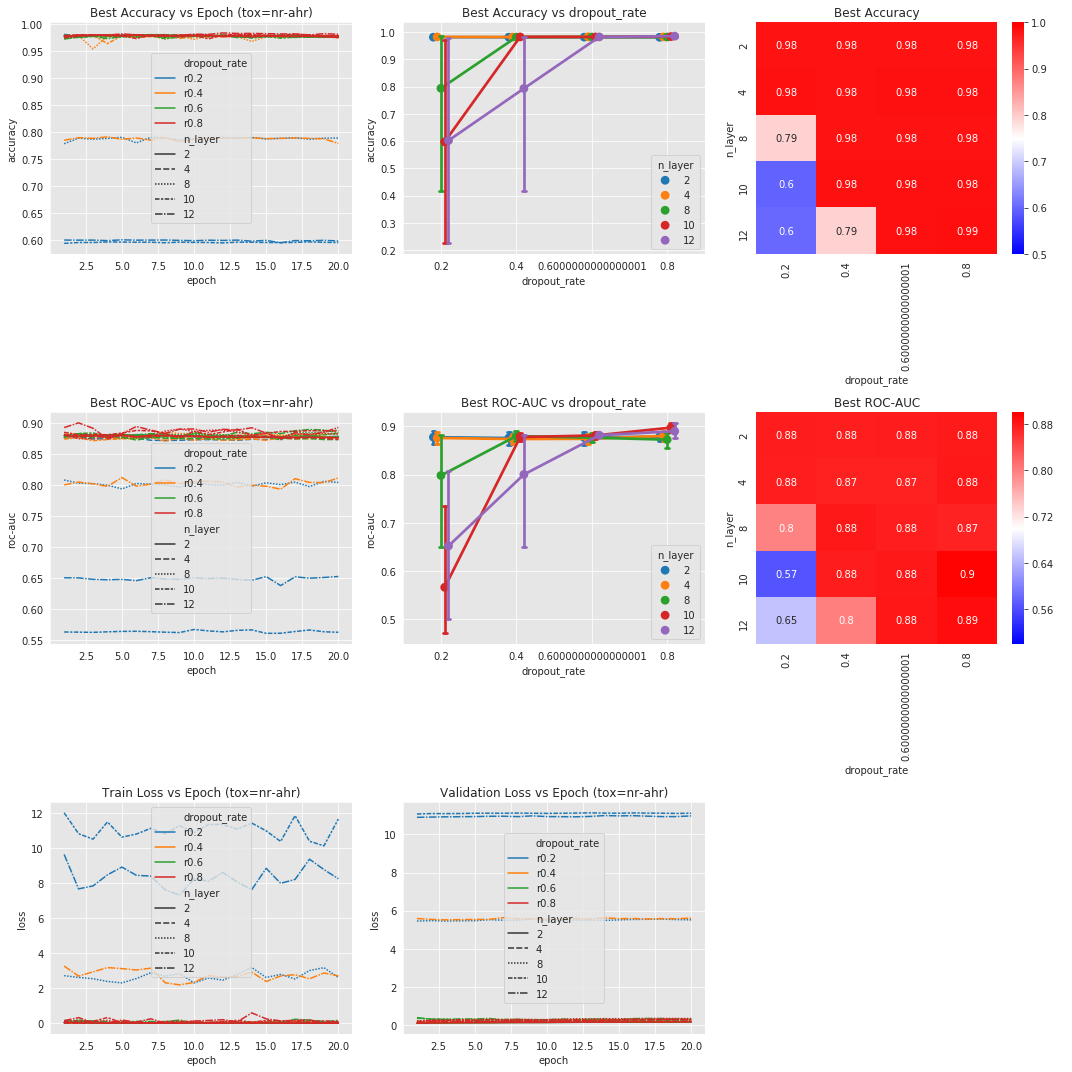

In [172]:
exp_name = 'exp_dropout_rate'

df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'n_layer', 'dropout_rate']]
df = df.loc[df['dropout_rate'] > 0]


variable = 'dropout_rate'
variable2 = 'n_layer'
list_loss = list()
list_test = list()

for value in df[variable].unique():
    for value2 in df[variable2].unique():
        for result in exp_data[exp_name]:
            if result[variable] == value and result[variable2] == value2:
                for i, data in enumerate(result['train_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'train', variable:'r'+str(value)[:3], variable2:value2})
                for i, data in enumerate(result['val_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'valid', variable:'r'+str(value)[:3], variable2:value2})
                for i, data in enumerate(result['acc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'acc', variable:'r'+str(value)[:3], variable2:value2})
                for i, data in enumerate(result['roc_auc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'roc_auc', variable:'r'+str(value)[:3], variable2:value2})
                break

df_loss = pd.DataFrame(list_loss)
df_test = pd.DataFrame(list_test)


fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_acc = df_test.loc[df_test['type'] == 'acc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_acc, ax=ax[0][0])
grid.set_title("Best Accuracy vs Epoch (tox=nr-ahr)")
grid.set_ylabel("accuracy")

df_acc = pd.DataFrame(df.groupby([variable2, variable])['acc'].mean())
df_acc.reset_index(level=df_acc.index.names, inplace=True)
df_acc = df_acc.pivot(index=variable2, columns=variable, values='acc')

grid = sns.pointplot(x=variable, y="acc", hue=variable2, data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[0][1])
grid.set_title("Best Accuracy vs {}".format(variable))
grid.set_ylabel("accuracy")
grid.grid(True)
grid = sns.heatmap(df_acc, annot=True, ax=ax[0][2], cmap='bwr', vmin=0.5, vmax=1.0)
grid.set_title("Best Accuracy")

df_roc_auc = df_test.loc[df_test['type'] == 'roc_auc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_roc_auc, ax=ax[1][0])
grid.set_title("Best ROC-AUC vs Epoch (tox=nr-ahr)")
grid.set_ylabel("roc-auc")

df_roc_auc = pd.DataFrame(df.groupby([variable2, variable])['roc_auc'].mean())
df_roc_auc.reset_index(level=df_roc_auc.index.names, inplace=True)
df_roc_auc = df_roc_auc.pivot(index=variable2, columns=variable, values='roc_auc')

grid = sns.pointplot(x=variable, y="roc_auc", hue=variable2, data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[1][1])
grid.set_title("Best ROC-AUC vs {}".format(variable))
grid.set_ylabel("roc-auc")
grid.grid(True)

grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][2], cmap='bwr', vmin=0.5, vmax=0.9)
grid.set_title("Best ROC-AUC")

df_train = df_loss.loc[df_loss['type'] == 'train']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_train, ax=ax[2][0])
grid.set_title("Train Loss vs Epoch (tox=nr-ahr)")

df_valid = df_loss.loc[df_loss['type'] == 'valid']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_valid, ax=ax[2][1])
grid.set_title("Validation Loss vs Epoch (tox=nr-ahr)")
ax[2][2].axis('off')

plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

## Result and Discussion  

- Both accuracy and roc-auc were increased when the model is deeper with higher dropout_rate.  
- A deeper model require higher dropout rate to perform as a shallow model with. 

# Experiment5. Effect of L2 regularization

In [ ]:
%%time
args.exp_name = 'exp_l2_coef'
args.input_dim = 2048
args.hidden_dim = 1024
args.output_dim = 1
args.dropout_rate = 0.0
args.lr = 0.001
args.optim = 'RMSProp'
args.epoch = 2
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.tox_type = 'nr-ahr'
exp_data[args.exp_name] = list()
list_l2_coef = [0, 0.0001, 0.001, 0.01, 0.1, 1.0]
list_n_layer = [2,4,8,10,12]

# pool = Pool(processes=14)
for n_layer in list_n_layer:
    for l2_coef in list_l2_coef:
        args.n_layer = n_layer
        args.l2_coef = l2_coef
        args.list_partition = dict_partition[tox_type]
        result = subproc_experiment(args)
        callback_experiment(result)
    #         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

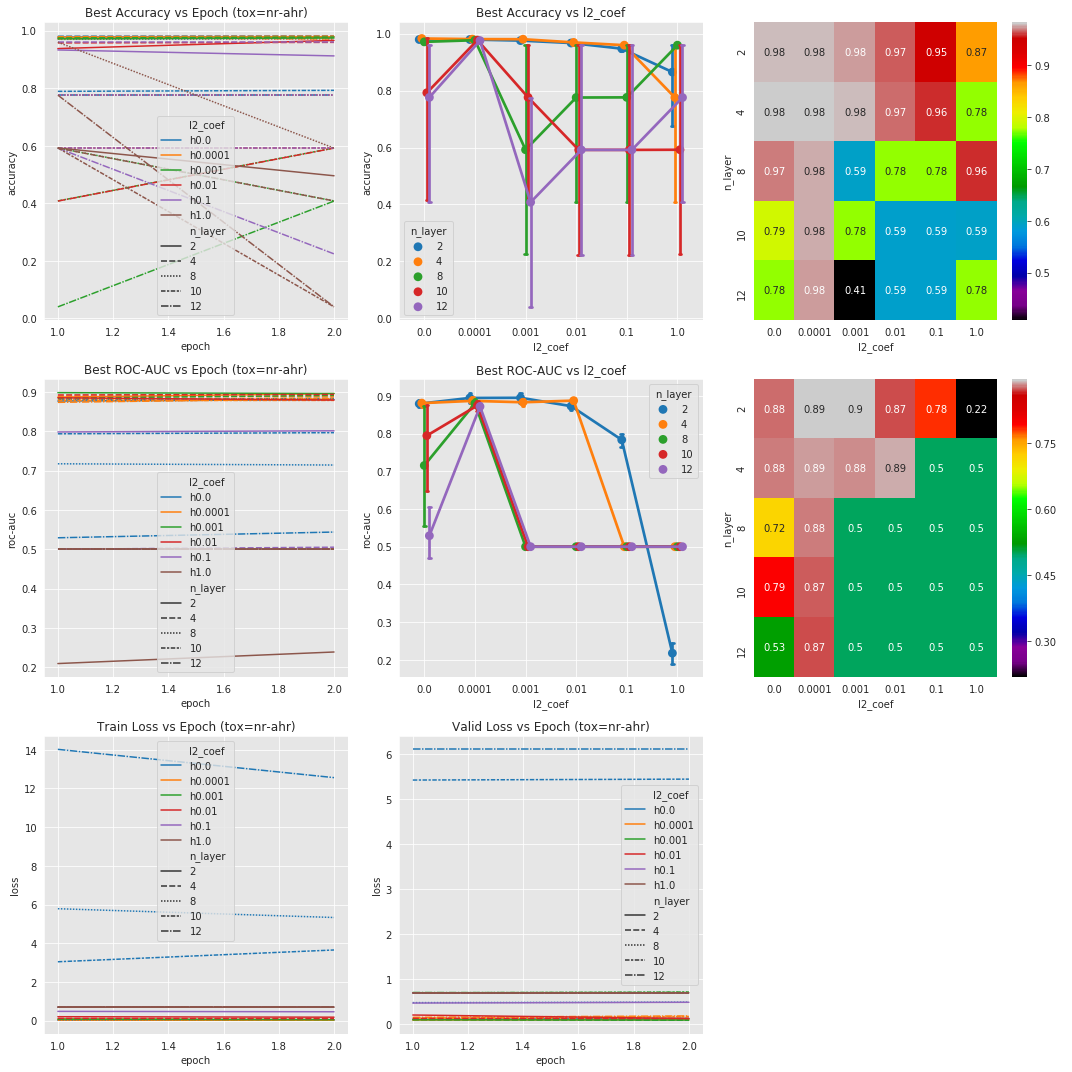

In [173]:
exp_name = 'exp_l2_coef'
df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'n_layer', 'l2_coef']]


variable = 'l2_coef'
variable2 = 'n_layer'
list_loss = list()
list_test = list()

for value in df[variable].unique():
    for value2 in df[variable2].unique():
        for result in exp_data[exp_name]:
            if result[variable] == value and result[variable2] == value2:
                for i, data in enumerate(result['train_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'train', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['val_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'valid', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['acc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'acc', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['roc_auc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'roc_auc', variable:'h'+str(value), variable2:value2})
                break

df_loss = pd.DataFrame(list_loss)
df_test = pd.DataFrame(list_test)


fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_acc = df_test.loc[df_test['type'] == 'acc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_acc, ax=ax[0][0])
grid.set_title("Best Accuracy vs Epoch (tox=nr-ahr)")
grid.set_ylabel("accuracy")

df_acc = pd.DataFrame(df.groupby([variable2, variable])['acc'].mean())
df_acc.reset_index(level=df_acc.index.names, inplace=True)
df_acc = df_acc.pivot(index=variable2, columns=variable, values='acc')

grid = sns.pointplot(x=variable, y="acc", hue=variable2, data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[0][1])
grid.set_title("Best Accuracy vs {}".format(variable))
grid.set_ylabel("accuracy")
grid.grid(True)
grid = sns.heatmap(df_acc, annot=True, ax=ax[0][2], cmap='nipy_spectral')

df_roc_auc = df_test.loc[df_test['type'] == 'roc_auc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_roc_auc, ax=ax[1][0])
grid.set_title("Best ROC-AUC vs Epoch (tox=nr-ahr)")
grid.set_ylabel("roc-auc")

df_roc_auc = pd.DataFrame(df.groupby([variable2, variable])['roc_auc'].mean())
df_roc_auc.reset_index(level=df_roc_auc.index.names, inplace=True)
df_roc_auc = df_roc_auc.pivot(index=variable2, columns=variable, values='roc_auc')

grid = sns.pointplot(x=variable, y="roc_auc", hue=variable2, data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[1][1])
grid.set_title("Best ROC-AUC vs {}".format(variable))
grid.set_ylabel("roc-auc")
grid.grid(True)
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][2], cmap='nipy_spectral')

df_train = df_loss.loc[df_loss['type'] == 'train']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_train, ax=ax[2][0])
grid.set_title("Train Loss vs Epoch (tox=nr-ahr)")

df_valid = df_loss.loc[df_loss['type'] == 'valid']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_valid, ax=ax[2][1])
grid.set_title("Valid Loss vs Epoch (tox=nr-ahr)")

ax[-1,-1].axis('off')
plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

## Result and Discussion  

- Again, epoch does not affect to the performance or even make worse. 
- L2 coef around 0.0001~0.001 increased the performance when the model has more than 8 layers.  
- L2 coef more than 0.001 decreased the performance regardless of the model depth.  


# Experiment6. Finding Best Dropout Rate and L2 Regularization  

Variable: Dropout rate, L2 coef, Number of hidden layer

In [ ]:
%%time
args.exp_name = 'exp_dropout_l2'
args.input_dim = 2048
args.hidden_dim = 1024
args.output_dim = 1
args.lr = 0.001
args.optim = 'RMSProp'
args.epoch = 2
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.tox_type = 'nr-ahr'
exp_data[args.exp_name] = list()
list_l2_coef = [0, 0.0001, 0.001, 0.01, 0.1, 1.0]
list_dropout_rate = [i*0.2 for i in range(5)]
list_n_layer = [2,4,8,10,12]

# pool = Pool(processes=14)
for n_layer in list_n_layer:
    for dropout_rate in list_dropout_rate:
        for l2_coef in list_l2_coef:
            args.dropout_rate = dropout_rate
            args.n_layer = n_layer
            args.l2_coef = l2_coef
            args.list_partition = dict_partition[tox_type]
            result = subproc_experiment(args)
            callback_experiment(result)
        #         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

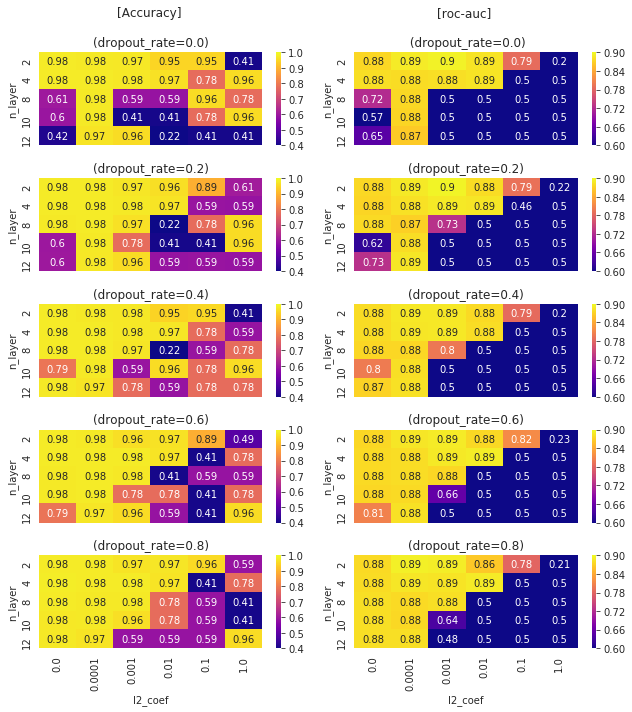

In [185]:
exp_name = 'exp_dropout_l2'
df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'n_layer', 'l2_coef', 'dropout_rate']]

variable = 'l2_coef'
variable2 = 'n_layer'
variable3 = 'dropout_rate'
list_loss = list()
list_test = list()



fig, ax = plt.subplots(len(df[variable3].unique()), 2)
fig.set_size_inches(9, 2*len(df[variable3].unique()))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_acc = pd.DataFrame(df.groupby([variable, variable2, variable3])['acc'].mean())
df_acc.reset_index(level=df_acc.index.names, inplace=True)
df_roc_auc = pd.DataFrame(df.groupby([variable, variable2, variable3])['roc_auc'].mean())
df_roc_auc.reset_index(level=df_roc_auc.index.names, inplace=True)

for i, value3 in enumerate(df[variable3].unique()):
    df_temp_acc = df_acc.loc[df_acc[variable3] == value3]
    df_temp_acc = df_temp_acc.pivot(index=variable2, columns=variable, values='acc')
    grid = sns.heatmap(df_temp_acc, annot=True, ax=ax[i][0], cmap='plasma', vmin=0.4, vmax=1.0)
    if i == 0:
        grid.set_title('[Accuracy] \n\n({}={:0.1f})'.format(variable3, value3))
    else:
        grid.set_title('({}={:0.1f})'.format(variable3, value3))

    if i != len(df[variable3].unique())-1:
        grid.get_xaxis().set_visible(False)

    df_temp_roc_auc = df_roc_auc.loc[df_roc_auc[variable3] == value3]
    df_temp_roc_auc = df_temp_roc_auc.pivot(index=variable2, columns=variable, values='roc_auc')
    grid = sns.heatmap(df_temp_roc_auc, annot=True, ax=ax[i][1], cmap='plasma', vmin=0.6, vmax=0.9)
    if i == 0:
        grid.set_title('[roc-auc] \n\n ({}={:0.1f})'.format(variable3, value3))
    else:
        grid.set_title('({}={:0.1f})'.format(variable3, value3))
        
    if i != len(df[variable3].unique())-1:
        grid.get_xaxis().set_visible(False)

plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

## Result and Discussion  

- With the low dropout rate, a shallow model with low l2 coef performed best.  
- As dropout rate increased, deeper model tend to be trained well.  
- However, l2_coef around 0.0001~0.001 were most effective while the number of the hidden layer is increased.  

# Comparsion with SVM model  

The result from https://github.com/heartcored98/CH485_AI_Chemistry/blob/master/Practice2_Tox21_SVM/Assignment2_Tox21_SVM.ipynb  

Show that SVM could achieve with 96% accuracy with 0.97 roc-auc. 
However, with the MLP model, 98% accuracy with 0.88 roc-auc was recorded.
Generally, SVM model outperformed MLP model in terms of roc-auc.  
For this reason, I expect that the MLP model is less trained due to the small size of the tox21 dataset.  
With bigger size dataset, a MLP model might outperform the SVM model.
